# Compare MA vs integrator bank sensitivity to local temporal structure

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from record_0_main import smlt_ma, smlt_lnma
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

In [2]:
N = 20

params_ma = {
    'TAU_R': np.random.uniform(20, 120, N),
    'TAU_A': np.random.uniform(.1, 2, N),
    'X_S': np.random.uniform(0, 1, N),
    'X_P': np.random.uniform(0, 1, N),
}

params_lnma = {
    'TAU_R': np.random.uniform(20, 120, N),
    # 'TAU_A': np.random.uniform(.1, 2, N),
    'TAU_A': np.repeat(np.inf, N),
    'X_S': np.random.uniform(0, 1, N),
    'X_P': np.random.uniform(0, 1, N),
}

(0.0, 20.0)

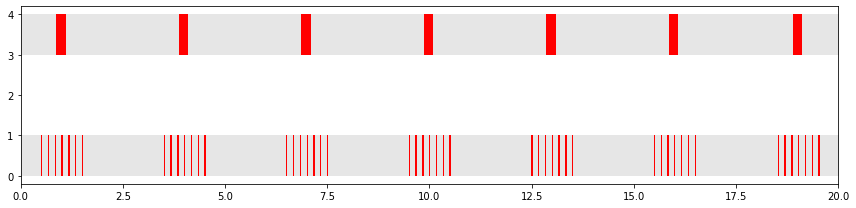

In [3]:
# get snippets
T_SNP = 300  # min snippet length to fetch
NT_SNP = int(round(T_SNP*FPS))
t_snp = np.arange(NT_SNP)*DT

snps = []
rs_full_ma = []
rs_full_lnma = []

# make two example trials

# short pulses
i_s_0 = np.zeros(NT_SNP)
i_p_0 = np.zeros(NT_SNP)

# long pulses
i_s_1 = np.zeros(NT_SNP)
i_p_1 = np.zeros(NT_SNP)

t_start = 1

while t_start < (T_SNP-10):
    it_start = int(round(t_start*FPS))
    
    # short pulses
    i_p_0[it_start-15] = 1
    i_p_0[it_start-10] = 1
    i_p_0[it_start-5] = 1
    i_p_0[it_start] = 1
    i_p_0[it_start+5] = 1
    i_p_0[it_start+10] = 1
    i_p_0[it_start+15] = 1
    
    # long pulse
    i_p_1[it_start-4:it_start+3] = 1
    
    t_start += 3
    
snp_0 = np.zeros(NT_SNP)
snp_0[i_s_0 == 1] = 1
snp_0[i_p_0 == 1] = 2

snp_1 = np.zeros(NT_SNP)
snp_1[i_s_1 == 1] = 1
snp_1[i_p_1 == 1] = 2
    
fig, ax = plt.subplots(1, 1, figsize=(12, 3), tight_layout=True)
plot_b(ax, t_snp, snp_0, extent=[0, t_snp.max(), 0, 1], c=[(.9, .9, .9), 'b', 'r'])
plot_b(ax, t_snp, snp_1, extent=[0, t_snp.max(), 3, 4], c=[(.9, .9, .9), 'b', 'r'])
ax.set_xlim(0, 20)

In [4]:
snps = [snp_0, snp_1]

In [5]:
for snp in snps:
    sys.stdout.write('.')

    i_s = (snp == 1).astype(float)
    i_p = (snp == 2).astype(float)

    t_snp = np.arange(len(snp))*DT

    rs_ma = smlt_ma(i_s, i_p, params_ma, DT)
    rs_full_ma.append(rs_ma)
    
    rs_lnma = smlt_lnma(i_s, i_p, params_lnma, DT)
    rs_full_lnma.append(rs_lnma)

..

## Trained readouts

In [6]:
y_0 = t_snp.copy()/t_snp.max()
y_1 = -y_0

## Fit to both targets together

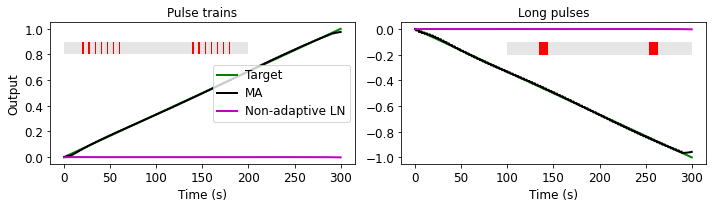

In [10]:
ALPHA = 1e-10
fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
axs[0].plot(t_snp, y_0, c='g', lw=2)
axs[1].plot(t_snp, y_1, c='g', lw=2)

for rs_full, color in zip([rs_full_ma, rs_full_lnma], ['k', 'm']):
    xs = cc(rs_full, axis=0)
    y = cc([y_0, y_1])
    
    rgr = linear_model.Ridge(alpha=ALPHA)
    rgr.fit(xs, y)
    
    y_hat_0 = rgr.predict(rs_full[0])
    y_hat_1 = rgr.predict(rs_full[1])
    
    axs[0].plot(t_snp, y_hat_0, c=color, lw=2)
    axs[1].plot(t_snp, y_hat_1, c=color, lw=2)
    
mt = (0 <= t_snp) & (t_snp < 5)
plot_b(axs[0], t_snp[mt], snp_0[mt], [0, 200, .8, .9], c=((.9, .9, .9), 'b', 'r'))
plot_b(axs[1], t_snp[mt], snp_1[mt], [100, 300, -.2, -.1], c=((.9, .9, .9), 'b', 'r'))
    
axs[0].legend(['Target', 'MA', 'Non-adaptive LN'], loc='center right')
set_plot(axs[0], x_label='Time (s)', y_label='Output', title='Pulse trains')
set_plot(axs[1], x_label='Time (s)', title='Long pulses')

fig.savefig('supp/4_ma_vs_pure_int_long_pulses_vs_trains.svg')

## Fit to individual targets

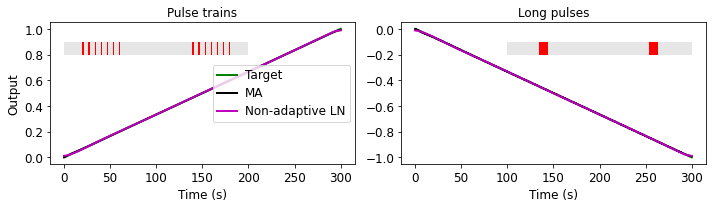

In [9]:
ALPHA = 1e-10
fig, axs = plt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
axs[0].plot(t_snp, y_0, c='g', lw=2)
axs[1].plot(t_snp, y_1, c='g', lw=2)

for rs_full, color in zip([rs_full_ma, rs_full_lnma], ['k', 'm']):
    rgr = linear_model.Ridge(alpha=ALPHA)
    rgr.fit(rs_full[0], y_0)
    
    y_hat_0 = rgr.predict(rs_full[0])
    axs[0].plot(t_snp, y_hat_0, c=color, lw=2)
    
    rgr = linear_model.Ridge(alpha=ALPHA)
    rgr.fit(rs_full[1], y_1)
    
    y_hat_1 = rgr.predict(rs_full[1])
    
    axs[1].plot(t_snp, y_hat_1, c=color, lw=2)
    
mt = (0 <= t_snp) & (t_snp < 5)
plot_b(axs[0], t_snp[mt], snp_0[mt], [0, 200, .8, .9], c=((.9, .9, .9), 'b', 'r'))
plot_b(axs[1], t_snp[mt], snp_1[mt], [100, 300, -.2, -.1], c=((.9, .9, .9), 'b', 'r'))
    
axs[0].legend(['Target', 'MA', 'Non-adaptive LN'], loc='center right')
set_plot(axs[0], x_label='Time (s)', y_label='Output', title='Pulse trains')
set_plot(axs[1], x_label='Time (s)', title='Long pulses')

fig.savefig('supp/4_ma_vs_pure_int_long_pulses_vs_trains_indiv.svg')